In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn import metrics
from sklearn import tree
from tqdm import tqdm
from collections import defaultdict

# For tree-wise complexity
from sklearn.ensemble._forest import _generate_unsampled_indices, _get_n_samples_bootstrap

from sklearn.metrics import log_loss, brier_score_loss
from joblib import Parallel, delayed
import multiprocessing

import sys
sys.path.append('../functions/')

import sys; sys.path.append('../PGDL/sample_code_submission/')
from internal_rep.matrix_funcs import \
    get_KF_Schatten_norms, \
    compute_complexity, \
    get_df_tau, \
    evalues_from_regions, \
    get_local_rad_bound

from utils import ece, generate_gaussian_parity
import argparse

import pickle

In [12]:
def generate_gaussian_parity(n, cov_scale=1, angle_params=None, k=1, acorn=None):
#     means = [[-1.5, -1.5], [1.5, 1.5], [1.5, -1.5], [-1.5, 1.5]]
    means = [[-1, -1], [1, 1], [1, -1], [-1, 1]]
    blob = np.concatenate(
        [
            np.random.multivariate_normal(
                mean, cov_scale * np.eye(len(mean)), size=int(n / 4)
            )
            for mean in means
        ]
    )

    X = np.zeros_like(blob)
    Y = np.concatenate([np.ones((int(n / 4))) * int(i < 2) for i in range(len(means))])
    X[:, 0] = blob[:, 0] * np.cos(angle_params * np.pi / 180) + blob[:, 1] * np.sin(
        angle_params * np.pi / 180
    )
    X[:, 1] = -blob[:, 0] * np.sin(angle_params * np.pi / 180) + blob[:, 1] * np.cos(
        angle_params * np.pi / 180
    )
    return X, Y.astype(int)


def get_tree(method='rf', max_depth=1, n_estimators=1, max_leaf_nodes = None ):
    if method == 'gb':
        rf = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=1514, max_leaf_nodes=max_leaf_nodes, learning_rate=1, criterion='mse')
    else:
        rf = RandomForestClassifier(bootstrap=False, max_depth=max_depth, n_estimators=n_estimators, random_state=1514, max_leaf_nodes=max_leaf_nodes)
    
    return rf

def gini_impurity(P1=0, P2=0):
    denom = P1 + P2
    Ginx = 2 * (P1/denom) * (P2/denom)
    return(Ginx)
def gini_impurity_mean(rf, data, label):
    leaf_idxs = rf.apply(data)
    predict = label
    gini_mean_score = []
    for t in range(leaf_idxs.shape[1]):
        gini_arr = []
        for l in np.unique(leaf_idxs[:,t]):
            cur_l_idx = predict[leaf_idxs[:,t]==l]
            pos_count = np.sum(cur_l_idx)
            neg_count = len(cur_l_idx) - pos_count
            gini = gini_impurity(pos_count, neg_count)
            gini_arr.append(gini) 

        gini_mean_score.append(np.array(gini_arr).mean())
    return np.array(gini_mean_score).mean()

def hellinger_explicit(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension
    """
    return np.mean(np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2, axis = 1)) / np.sqrt(2))

def pdf(x):
    mu01, mu02, mu11, mu12 = [[-1, -1], [1, 1], [-1, 1], [1, -1]]
   
    cov = 1 * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    return [p1/(p0+p1), p0/(p0+p1)]

def indices_to_one_hot(data):
    """
    Convert an iterable of indices to one-hot encoded labels.
    Input: data - 1D numpy array with integers
    Output: one-hot encoding matrix , with shape (len(data) x len(data))
    """
    nb_classes = data.max()
    return np.eye(nb_classes+1)[data]

def proximityMatrix(terminals, normalize=True, internal=True):      
    '''
    Return the internal representation of a RF model
    Input: terminals - leaf_idx
    '''
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    if internal:
        internalMatrices = [indices_to_one_hot(a)]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)
        if internal:
            internalMatrices.append(indices_to_one_hot(a))

    if normalize:
        proxMat = proxMat / nTrees
    
    if internal:
        return proxMat, internalMatrices
    else:
        return proxMat  

def one_run(xx, yy, true_posterior, rep_i, N, max_node, n_est, method='rf', exp_alias='depth'): 
    '''
    Run one simulation (when no multicores available, avoid memory issue)
    max_node: controls whether we grow 'deep' forest or 'shallow' forest
    '''
    X_train, y_train = generate_gaussian_parity(n=N, angle_params=0)
    X_test, y_test = generate_gaussian_parity(n=1000, angle_params=0)

    rf = get_tree(method, max_depth=1)
    results = defaultdict(list)
    # for rep_i in range(reps):
    for depth in tqdm(range(1, max_node + n_est), position=0, leave=True):
        if depth < max_node:
            rf.max_depth += 1
        else:
            rf.n_estimators += 3
            rf.max_depth += 15
            # rf.warm_start=True
        #x-axis
        results['max_depth'].append(rf.max_depth)

        rf.fit(X_train, y_train)

        results['nodes'].append(sum([estimator.get_n_leaves() for estimator in rf.estimators_]))
        leaf_idxs = rf.apply(X_train)
        #store internal matrices when varying RF architecture
        tree_h_stars = []
        tree_h_argmins = []
        forest_gram = np.zeros((N, N))
        
        n_samples_bootstrap = _get_n_samples_bootstrap(N, rf.max_samples)
        for tree in rf.estimators_:
            # Here at each iteration we obtain out of bag samples for every tree.
            unsampled_indices = _generate_unsampled_indices(
                tree.random_state, N, n_samples_bootstrap)
            sampled_indices = np.setdiff1d(np.arange(N), unsampled_indices)
            leaf_idx = tree.apply(X_train[sampled_indices])
            h_star, h_argmin = get_local_rad_bound(
                evalues_from_regions(leaf_idx),
                normalize=True, from_evalues=True)
            tree_h_stars.append(h_star)
            tree_h_argmins.append(h_argmin)
            
            leaf_idx = tree.apply(X_train)
            forest_gram += 1*np.equal.outer(leaf_idx, leaf_idx)
        forest_gram /= len(rf.estimators_)
        
        forest_h_star, forest_h_argmin = get_local_rad_bound(forest_gram, normalize=True, from_gram=True)
        results['forest_h*'].append(forest_h_star)
        results['forest_h_argmin'].append(forest_h_argmin)
        
        results['tree_h*'].append(np.mean(tree_h_stars))
        results['tree_h_argmin'].append(np.mean(tree_h_argmins))  
        
        results['polys'].append(len(np.unique(leaf_idxs)))
        results['gini_score_train'].append(gini_impurity_mean(rf, X_train, y_train))
        results['gini_score_test'].append(gini_impurity_mean(rf, X_test, y_test))
        results['train_error'].append(1 - rf.score(X_train, y_train))
        results['test_error'].append(1 - rf.score(X_test, y_test))
        results['train_error_log'].append(log_loss(y_train, rf.predict(X_train)))
        results['test_error_log'].append(log_loss(y_test, rf.predict(X_test)))
        rf_posteriors_grid = rf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        results['ece_error'].append(hellinger_explicit(rf_posteriors_grid, true_posterior))

    #pickle.dump( results, open('/content/drive/MyDrive/JHU/NIPS/double_descent-teresa/results/xor_rf_dd_'+ exp_alias + '_' + str(rep_i) + ".pkl", "wb" ) )
    return results

def rf_dd_exp(N=4096, reps=100, max_node=None, n_est=10, exp_alias = "depth", method='rf'):
    
    xx, yy = np.meshgrid(np.arange(-2, 2, 4 / 100), np.arange(-2, 2, 4 / 100))
    true_posterior = np.array([pdf(x) for x in (np.c_[xx.ravel(), yy.ravel()])])
    X_train, y_train = generate_gaussian_parity(n=N, angle_params=0)
    result_all = []

    if max_node is None: #for depth: max_node set to None ; for width: max_node set to 15
        rf = get_tree(method, max_depth=None) #grow to pure leaves
        rf.fit(X_train, y_train)
        max_node = sum([estimator.get_n_leaves() for estimator in rf.estimators_]) #+50
    
    for rep_i in range(reps):
        result_run = one_run(xx, yy, true_posterior, rep_i, N, max_node, n_est, method, exp_alias)
        result_all.append(result_run)
    
    pickle.dump( result_all, open('../results/xor_rf_dd_'+ exp_alias + ".pkl", "wb" ) )
    return result_all

In [13]:
iterations = 5 # the number of repetitions of a single run of the algorithm

In [14]:
# Run DeepRF
error_d = rf_dd_exp(N=1000, reps=iterations)

100%|██████████| 346/346 [00:58<00:00,  5.88it/s]


In [15]:
# Run ShallowRF
error_w = rf_dd_exp(N=1000, max_node=5, n_est=30, reps=iterations, exp_alias='width')

100%|██████████| 34/34 [00:26<00:00,  1.28it/s]


In [16]:
from scipy import stats

def compute_tau(gen_err, metric, inverse=False):
    '''
    Input: array (generalization err); array (metric computed for the model instance at such a generalization gap); 
    - If inverse: first take inverse of the metric, and compute the kendall tau coefficient
    Return: kendall's tau coefficient, pvalue
    '''
    if inverse:
        metric = np.array([1/elem for elem in metric])
    tau, p_value = stats.kendalltau(gen_err, metric, nan_policy='omit')
    return tau, p_value

def aggregate_result(error_dict, iterations=5, key='rs'):
    '''
    Return: 
    - flatten all results
    - average results on fixed max_depth architecture
    '''
    if key == 'gen_gap':
        key_all = np.array([np.array(error_dict[i]['test_error']) - np.array(error_dict[i]['train_error'])
                            for i in range(iterations)])
    else:
        key_all = np.array([np.array(error_dict[i][key]) for i in range(iterations)])
    return key_all, np.mean(key_all, axis=0)                                    

In [17]:
import pickle
error_d = pickle.load(open("../results/xor_rf_dd_depth.pkl", "rb"))
error_w = pickle.load(open("../results/xor_rf_dd_width.pkl", "rb"))

In [65]:
for method, error in zip(['Depth', 'Width'], [error_d, error_w]):
    gen_gap_all, gen_gap_mean = aggregate_result(error, iterations=iterations, key='gen_gap')
    nodes_all, nodes_mean = aggregate_result(error, iterations=iterations, key='nodes')
    train_all, train_mean = aggregate_result(error, iterations=iterations, key='train_error')
    test_all, test_mean = aggregate_result(error, iterations=iterations, key='test_error')
    for complexity in ['forest', 'tree']:
        h_star_all, h_star_mean = aggregate_result(error, iterations=iterations, key=f'{complexity}_h*')
        h_argmin_all, h_argmin_mean = aggregate_result(error, iterations=iterations, key=f'{complexity}_h_argmin')

        print(f'{method}, {complexity} [mean (std)]:')
        for metric_name, metric_all in zip(['gen_gap', 'train_error', 'test_error'], [gen_gap_all, train_all, test_all]):
            # tau, pvalue = compute_tau(metric_all.mean(0), h_star_mean)
            # print(f'- tau({metric_name}: {tau}, {pvalue}')
            taus, pvalues = list(zip(*[
                compute_tau(metric, h_star) for metric, h_star in zip(metric_all, h_star_all)
            ]))
            print(f'- tau({metric_name}) = {np.mean(taus):.3f} ({np.std(taus):.3f})), ' +
                  f'pval={np.mean(pvalues):.3f} ({np.std(pvalues):.3f})')

Depth, forest [mean (std)]:
- tau(gen_gap) = 0.654 (0.134)), pval=0.000 (0.000)
- tau(train_error) = -0.565 (0.140)), pval=0.000 (0.000)
- tau(test_error) = 0.364 (0.211)), pval=0.000 (0.000)
Depth, tree [mean (std)]:
- tau(gen_gap) = 0.185 (0.286)), pval=0.335 (0.314)
- tau(train_error) = -0.530 (0.038)), pval=0.000 (0.000)
- tau(test_error) = -0.086 (0.322)), pval=0.007 (0.014)
Width, forest [mean (std)]:
- tau(gen_gap) = 0.245 (0.039)), pval=0.095 (0.050)
- tau(train_error) = -0.531 (0.071)), pval=0.002 (0.002)
- tau(test_error) = -0.205 (0.177)), pval=0.118 (0.126)
Width, tree [mean (std)]:
- tau(gen_gap) = 0.232 (0.149)), pval=0.236 (0.259)
- tau(train_error) = -0.387 (0.068)), pval=0.011 (0.009)
- tau(test_error) = -0.107 (0.178)), pval=0.477 (0.394)


Depth


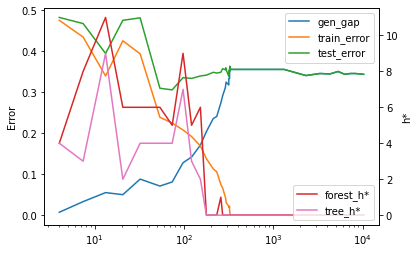

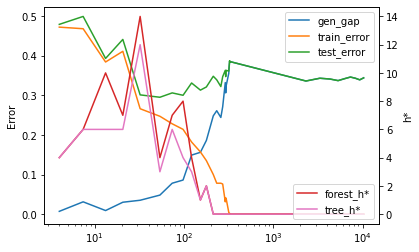

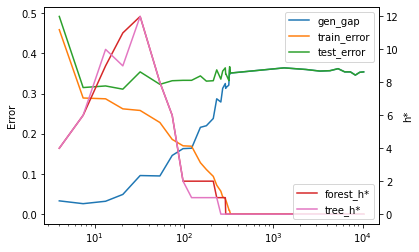

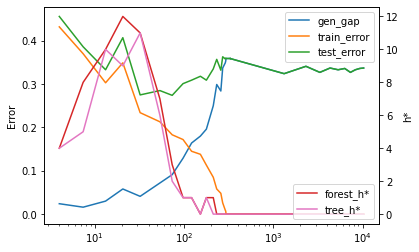

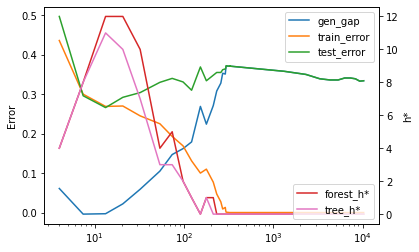

Width


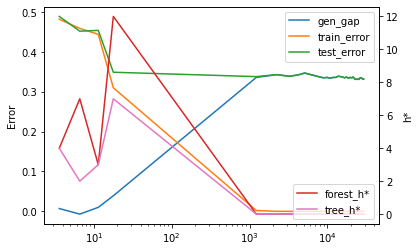

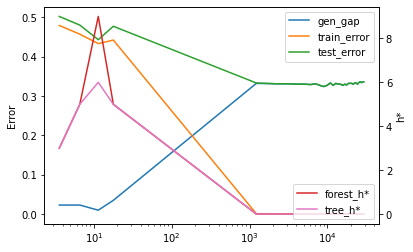

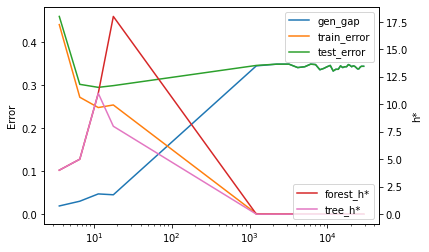

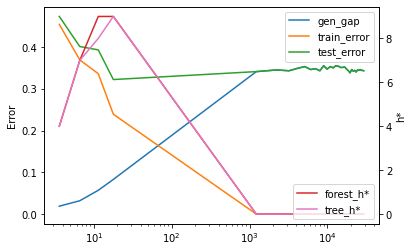

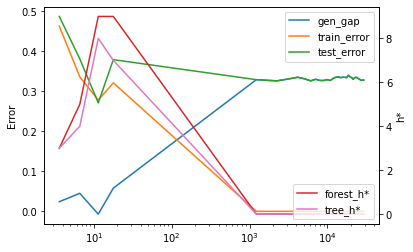

In [64]:
for method, error in zip(['Depth', 'Width'], [error_d, error_w]):
    gen_gap_all, gen_gap_mean = aggregate_result(error, iterations=iterations, key='gen_gap')
    nodes_all, nodes_mean = aggregate_result(error, iterations=iterations, key='nodes')
    train_all, train_mean = aggregate_result(error, iterations=iterations, key='train_error')
    test_all, test_mean = aggregate_result(error, iterations=iterations, key='test_error')
    print(f'{method}')
    for i in range(5):
        f, ax = plt.subplots(1, 1)
        for metric_name, metric_all in zip(['gen_gap', 'train_error', 'test_error'], [gen_gap_all, train_all, test_all]):
            ax.plot(nodes_mean, metric_all[i], label=metric_name)
        ax2 = ax.twinx()
        ax.set_ylabel('Error')
        ax2.set_ylabel('h*')
        for complexity, c in zip(['forest', 'tree'], ['tab:red', 'tab:pink']):
            h_star_all, h_star_mean = aggregate_result(error, iterations=iterations, key=f'{complexity}_h*')
            h_argmin_all, h_argmin_mean = aggregate_result(error, iterations=iterations, key=f'{complexity}_h_argmin')
            ax2.plot(nodes_mean, h_argmin_all[i], label=f'{complexity}_h*', c=c)
        plt.xscale('log')
        ax.legend(loc='upper right')
        ax2.legend(loc='lower right')
        plt.show()

In [49]:
def subplot_complexity(nodes, gen_gap, train_error, test_error, hs_forest, hs_tree_all, ax, label='left'):
    '''
    plot complexity for depth/width set of experiment
    '''
    ax.plot(nodes, hs_forest, linestyle='-', marker='X', label='forest h*', color='tab:red')
    
    tree_mean = hs_tree_all.mean(0)
    tree_std = hs_tree_all.std(0)
    ax.plot(nodes, tree_mean, linestyle='-', marker='X', label='tree h*', color='tab:pink')
    ax.fill_between(nodes, tree_mean - 2*tree_std, tree_mean + 2*tree_std, alpha=0.2, color='tab:pink')
    ax2 = ax.twinx()
    for l, metric in zip(['gen_gap', 'train_error', 'test_error'], [gen_gap, train_error, test_error]):
        ax2.plot(nodes, metric, marker='o', label=l)

    ax.set_xlabel('Total parameters (nodes)', size=15)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if label=='left':
        ax.set_ylabel(r'Upper bound of complexity measure $h*$', size=15)
    else:
        ax2.set_ylabel(r'Errors',  size=15)
    ax.legend(fontsize=12, loc='upper right')
    ax2.legend(fontsize=12, loc='lower right')

def subplot_h(nodes, forest_hs, tree_hs, ax):
    #plot h
    ax.plot(nodes, forest_hs, linestyle='-', marker='X', color='tab:red',label=r'forest $\arg \min$ h')
    ax.plot(nodes, tree_hs, linestyle='-', marker='X', color='tab:pink',label=r'tree $\arg \min$ h')
    #ax.plot(error_dict['nodes'], rad_results_norm['avg_L'],  marker='o', color='tab:orange',label=r'average number of regions L')
    ax.set_xlabel('Total parameters (nodes)', size=15)
    ax.set_ylabel(r'Number of $h$ or $L$', size=15)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.axhline(1, linestyle=':', color='black', alpha=0.5)
    ax.legend(fontsize=12, loc='best')

In [50]:
gen_gap_all, gen_gap_mean = aggregate_result(error_d, iterations=iterations, key='gen_gap')
forest_h_star_all, forest_h_star_mean = aggregate_result(error_d, iterations=iterations, key=f'forest_h*')
forest_h_argmin_all, forest_h_argmin_mean = aggregate_result(error_d, iterations=iterations, key=f'forest_h_argmin')
tree_h_star_all, tree_h_star_mean = aggregate_result(error_d, iterations=iterations, key=f'tree_h*')
tree_h_argmin_all, tree_h_argmin_mean = aggregate_result(error_d, iterations=iterations, key=f'tree_h_argmin')
nodes_all, nodes_mean = aggregate_result(error_d, iterations=iterations, key='nodes')
train_all, train_mean = aggregate_result(error_d, iterations=iterations, key='train_error')
test_all, test_mean = aggregate_result(error_d, iterations=iterations, key='test_error')


gen_gap_all_w, gen_gap_mean_w = aggregate_result(error_w, iterations=iterations, key='gen_gap')
forest_h_star_all_w, forest_h_star_mean_w = aggregate_result(error_w, iterations=iterations, key=f'forest_h*')
forest_h_argmin_all_w, forest_h_argmin_mean_w = aggregate_result(error_w, iterations=iterations, key=f'forest_h_argmin')
tree_h_star_all_w, tree_h_star_mean_w = aggregate_result(error_w, iterations=iterations, key=f'tree_h*')
tree_h_argmin_all_w, tree_h_argmin_mean_w = aggregate_result(error_w, iterations=iterations, key=f'tree_h_argmin')
nodes_all_w, nodes_mean_w = aggregate_result(error_w, iterations=iterations, key='nodes')
train_all_w, train_mean_w = aggregate_result(error_w, iterations=iterations, key='train_error')
test_all_w, test_mean_w = aggregate_result(error_w, iterations=iterations, key='test_error')

In [51]:
forest_tau_d,_ = compute_tau(gen_gap_all.mean(0), forest_h_star_mean)
forest_tau_w,_ = compute_tau(gen_gap_all_w.mean(0), forest_h_star_mean_w)

tree_tau_d,_ = compute_tau(gen_gap_all.mean(0), tree_h_star_mean)
tree_tau_w,_ = compute_tau(gen_gap_all_w.mean(0), tree_h_star_mean_w)

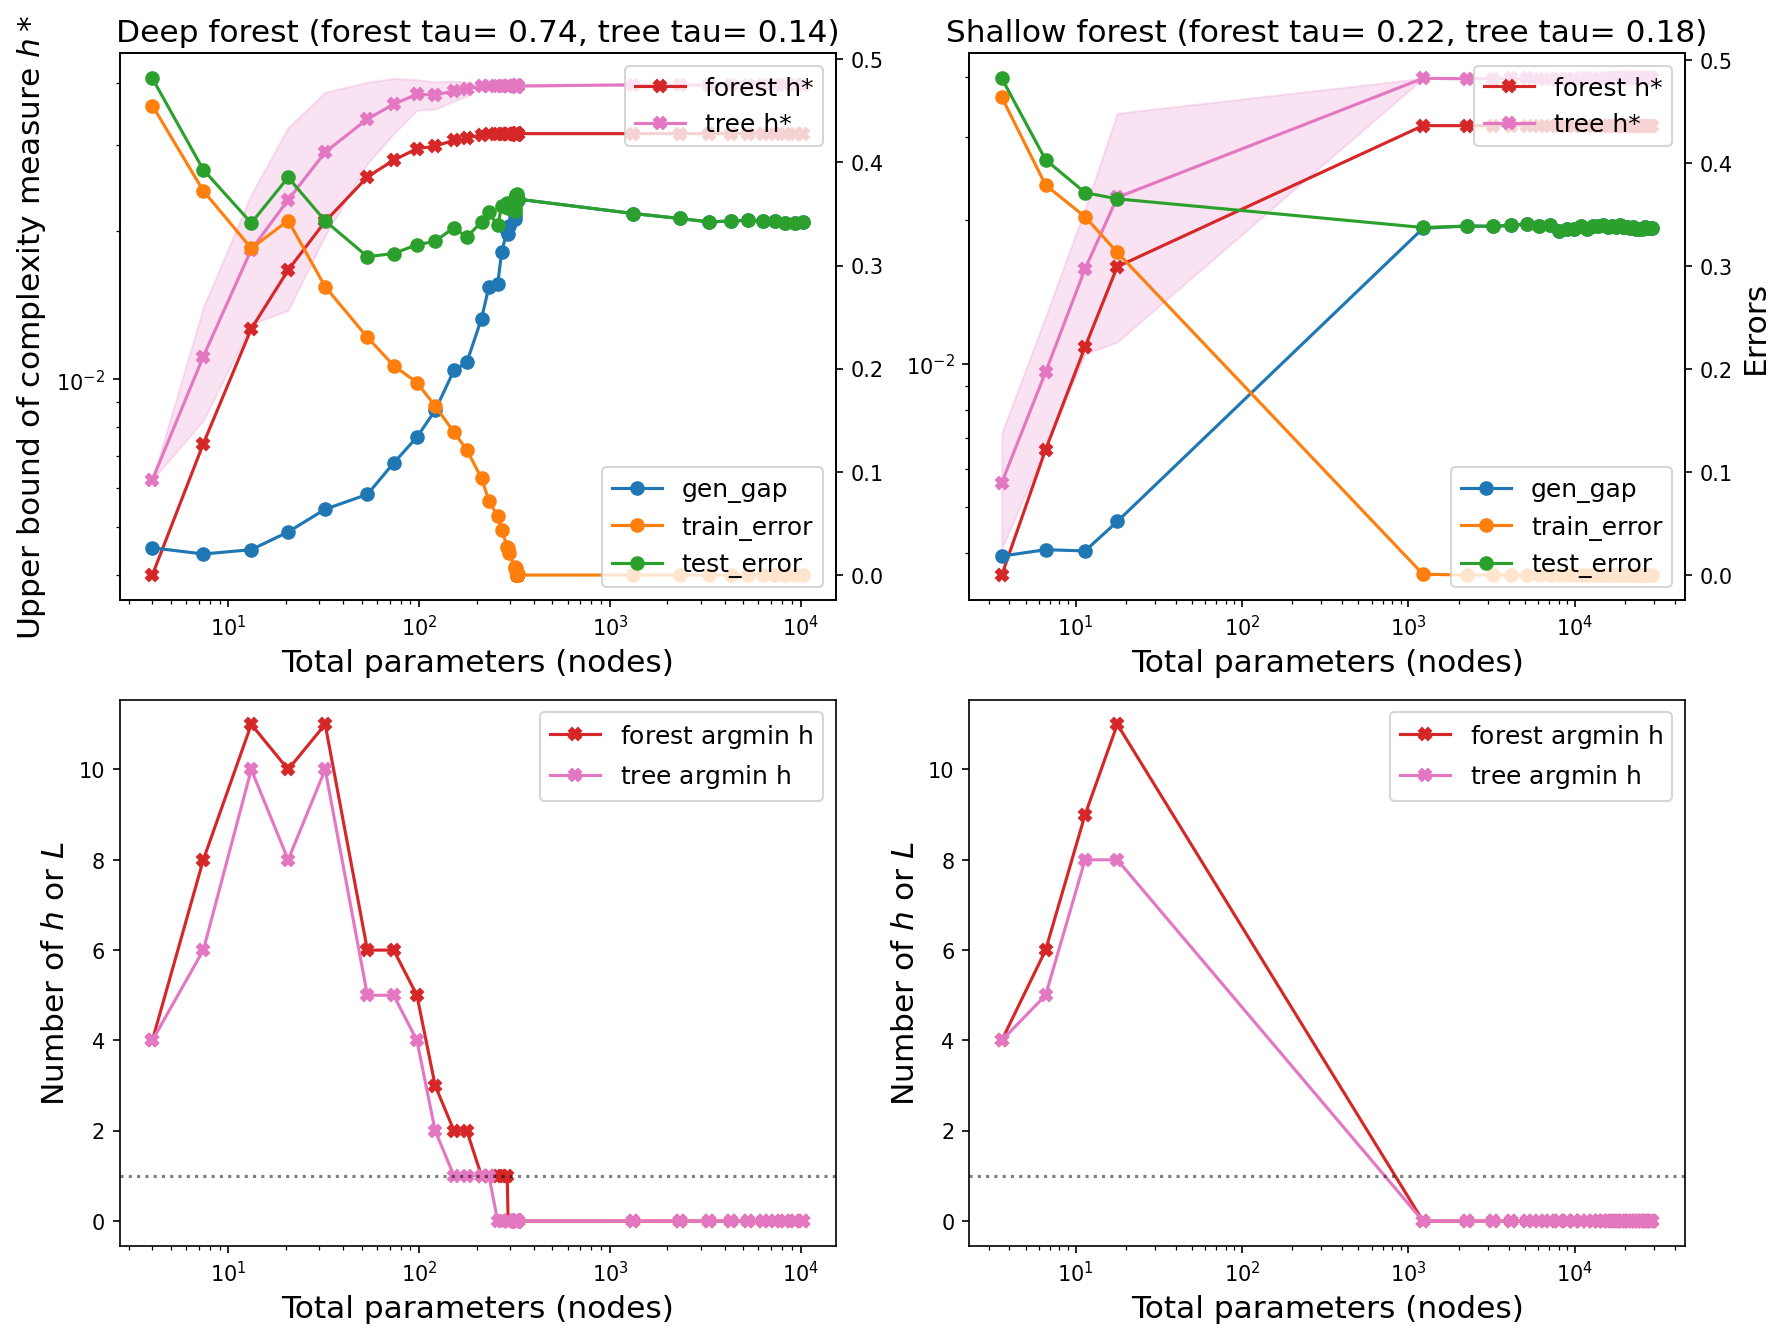

In [53]:
#overall (average over 10 reps per architecture axis)
fig, axs = plt.subplots(ncols=2, nrows=2, dpi=150, figsize=(12,9))
axs = axs.flat
for ax in axs:
    ax.grid(False)
#depth
subplot_complexity(
    nodes_mean, gen_gap_mean, train_mean, test_mean, forest_h_star_mean, tree_h_star_all, axs[0], label='left')
#width
subplot_complexity(
    nodes_mean_w, gen_gap_mean_w, train_mean_w, test_mean_w, forest_h_star_mean_w, tree_h_star_all_w, axs[1], label='right')
#plot h
subplot_h(nodes_mean, np.ceil(forest_h_argmin_mean), np.ceil(tree_h_argmin_mean), axs[2])
subplot_h(nodes_mean_w, np.ceil(forest_h_argmin_mean_w), np.ceil(tree_h_argmin_mean_w), axs[3])

axs[0].set_title(f"Deep forest (forest tau= {forest_tau_d:.2f}, tree tau= {tree_tau_d:.2f})",fontsize=15)
axs[1].set_title(f"Shallow forest (forest tau= {forest_tau_w:.2f}, tree tau= {tree_tau_w:.2f})",fontsize=15)
fig.tight_layout()
plt.show()